<a href="https://colab.research.google.com/github/woonghee97/deep_learning/blob/DeepLearning/MiniProj_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproject#3 장소 인식


## 1.소개 
딥러닝 및 컴퓨터비전에서 장소 인식은 아래의 단계를 거쳐서 이뤄집니다.
1. 이미지에서 장소를 대표하는 하나의 global descriptor를 추출한다. 
2. 비교하려는 이미지 간에 global descriptor 사이의 유사도를 비교하여 가장 유사도가 높은 이미지로 장소를 찾아낸다.  

이번 프로젝트는 각자의 방법으로 global descriptor를 비교해 장소인식을 구현하는 것입니다. 예제로 convolutional autoencoder,vgg16의 CNN 구조에 FC레이어를 추가한 모델의 출력으로 global descriptor를 만드는 것입니다. 
이렇게 만든 같은 장소의 global descriptor들은 이미지를 찍은 시점, 계절, 빛의 세기에 관계없이 유사도가 가장 높아지는 것을 목표로 합니다. 

이번에 사용할 데이터셋은 이미지를 찍은 시점, 빛의 세기는 같지만, 계절이 여름과 가을로 다른 장소 이미지를 사용합니다. 이미지를 직접 가져와서 확인해봅시다.

## 2.먼저 구글드라이브와 colab을 연동해봅시다.

아래의 코드를 실행하여 이미지를 로드합니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


    Mounted at /content/drive/ 
라는 문구가 나왔다면 성공입니다.아래의 명령어를 실행하여

    /content/drive/My Drive
이 나왔는지 확인해주세요

In [2]:
!pwd

/content/drive/My Drive


## 3.train set으로 이미지와 이름확인하기

일단 train set을 모두 가져옵니다. google drive에 **'place_recognition'** 폴더를 만들고 업로드한 파일의 압축을 풀어주시길 바랍니다.

In [18]:
import numpy as np

train_summer = np.load("./place_recognition/summer_train_150.npy")
train_fall = np.load("./place_recognition/fall_train_150.npy")
test_summer = np.load("./place_recognition/test_summer.npy")
test_fall = np.load("./place_recognition/test_fall.npy")
print("summer image shape is ", train_summer.shape)
print("fall image shape is ", train_fall.shape)
print("summer image shape is ", test_summer.shape)
print("fall image shape is ", test_fall.shape)

summer image shape is  (3000, 150, 150, 3)
fall image shape is  (3000, 150, 150, 3)
summer image shape is  (250, 150, 150, 3)
fall image shape is  (250, 150, 150, 3)


이제 해당 이미지들을 확인합니다.

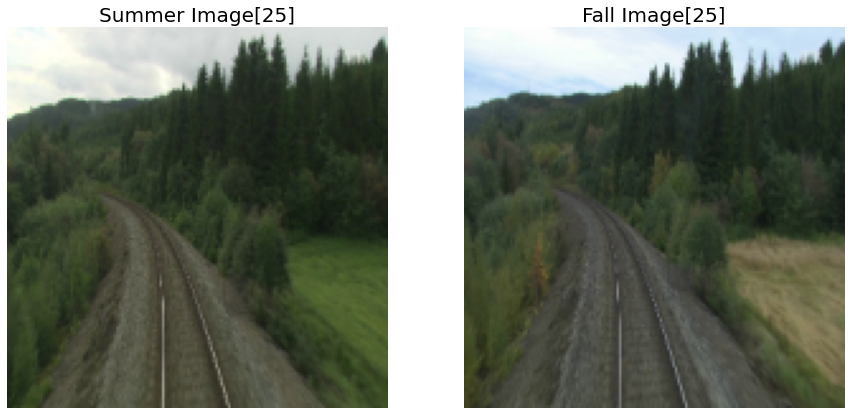

In [19]:
import matplotlib.pyplot as plt
import cv2
def draw_place_image(summer_images, fall_images, image_index):
  fig =plt.figure()
  fig.set_size_inches(15,10.5,forward=True)
  rows=1
  cols=2
  if image_index >=3000:
    image_index =2999
  #저장된 이미지는 vgg16의 입력 이미지와 같은 BGR채널을 가지는 이미지입니다. 
  #해당이미지를 RGB이미지로 변환하여 확인합니다.
  RGB_summer_image =cv2.cvtColor(summer_images[image_index], cv2.COLOR_BGR2RGB)
  RGB_fall_image =cv2.cvtColor(fall_images[image_index], cv2.COLOR_BGR2RGB)
  ax1 = fig.add_subplot(rows,cols,1)
  ax1.imshow(RGB_summer_image)
  ax1.set_title('Summer Image['+str(image_index)+"]",fontsize=20)
  ax1.axis("off")

  ax2 = fig.add_subplot(rows,cols,2)
  ax2.imshow(RGB_fall_image)
  ax2.set_title('Fall Image['+str(image_index)+"]",fontsize=20)
  ax2.axis("off")

draw_place_image(train_summer, train_fall, 25)

오른쪽 이미지가 좀더 가을 계절처럼 보이나요?

## 4.불러온 이미지 전처리

이제 불러온 이미지를 모델의 입력으로 넣을 수 있게 끔 아래의 과정을 진행해야합니다.
- 이미지를 BGR이미지로 변환
- 0과 255 사이에서 0과 1사이의 값으로 변환

첫 번째인 BGR이미지 변환은 이미되어있고 , 아래의 코드를 실행하여 이미지를 0과 1사이의 값으로 바꿉니다.

In [20]:
train_summer = train_summer / 255.0
train_fall = train_fall/255.0
test_summer = test_summer / 255.0
test_fall = test_fall / 255.0

## 5.Convolutional Autoencoder(CAE)를 통한 descriptor 추출



CAE는 입력된 데이터를 압축하는 모델로 데이터의 특징을 추출할 수 있는 기능, 압축에의한 손실, 사람의 개입이 없는 자동학습이라는 특징을 가지고 있습니다. 아래의 링크를 통해서 자세한 정보를 확인할 수 있습니다.
(https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/)

이번 프로젝트에서 사용될 특징은 데이터의 특징을 추출하는 것입니다. 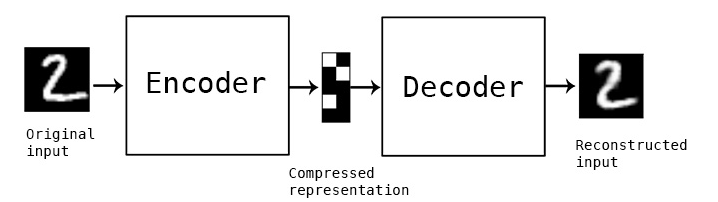

위 사진에서 확인할 수 있듯이 Encoder를 통해서 이미지를 특징점을 가지는 global descriptor로 압축하는 것이 가능합니다. 아래의 간단한 모델을 통해서 확인해 보겠습니다.

In [13]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(150, 150, 3))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((5, 5), padding='same')(x)
x = Flatten()(x)
encoded = Dense(100, activation='relu')(x)

# Encoder model
encoder = Model(input_img, encoded)
#encoder.summary()

Decoded_img = Input(shape=(100,))
x = Dense(5*5*8)(Decoded_img)
x = Reshape((5,5,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((5, 5))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(Decoded_img, decoded)
#decoder.summary()

x = encoder(input_img)
decoder_out = decoder(x)
autoencoder = Model(input_img, decoder_out)
#autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"] )

In [5]:
from keras.engine.training import saver_with_op_caching
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(150, 150, 3))  


x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((5, 5), padding='same')(x)
x = Flatten()(x)
encoded = Dense(100, activation='relu')(x)


# Encoder model
encoder = Model(input_img, encoded)
#encoder.summary()

Decoded_img = Input(shape=(100,))
x = Dense(5*5*8)(Decoded_img)
x = Reshape((5,5,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((5, 5))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(Decoded_img, decoded)
#decoder.summary()

x = encoder(input_img)
decoder_out = decoder(x)
autoencoder = Model(input_img, decoder_out)
#autoencoder.summary()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
autoencoder.compile(optimizer="adam", loss=bce, metrics=["accuracy"] )

checkpoint_filepath = '/content/drive/MyDrive/DeepLearning_MiniProject3/model_weights/{epoch:02d}-{accuracy:.4f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch'
)

위에서 생성한 모델을 (summer,fall), (summer,summer), (fall, summer), (fall, fall) 쌍으로 학습을 통해서 global desicriptor를 생성하는 것이 가능합니다.

아래에서는 (summer, summer)를 조건으로 학습을 진행합니다.

In [19]:
autoencoder.fit(train_summer, train_summer, batch_size = 10, epochs= 200, callbacks=[model_checkpoint_callback])

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


300/300 [==============================] - 9s 23ms/step - loss: 126226.8594 - accuracy: 0.7216
Epoch 2/200
300/300 [==============================] - 7s 23ms/step - loss: 118738.9531 - accuracy: 0.7421
Epoch 3/200
300/300 [==============================] - 7s 24ms/step - loss: 118101.1953 - accuracy: 0.7546
Epoch 4/200
300/300 [==============================] - 7s 23ms/step - loss: 117682.7344 - accuracy: 0.7568
Epoch 5/200
300/300 [==============================] - 7s 24ms/step - loss: 117412.1250 - accuracy: 0.7581
Epoch 6/200
300/300 [==============================] - 7s 24ms/step - loss: 117253.4609 - accuracy: 0.7598
Epoch 7/200
300/300 [==============================] - 7s 24ms/step - loss: 117155.9609 - accuracy: 0.7612
Epoch 8/200
300/300 [==============================] - 7s 23ms/step - loss: 116958.8984 - accuracy: 0.7618
Epoch 9/200
300/300 [==============================] - 7s 23ms/step - loss: 116811.1250 - accuracy: 0.7633
Epoch 10/200
300/300 [===========================

In [7]:
import keras
from keras.models import save_model, load_model

# autoencoder.save('drive/MyDrive/model/proj3(2).h5')
autoencoder = keras.models.load_model("drive/MyDrive/model/proj3(2).h5")


### 5-1.descriptor 추출
위에서 학습한 autoencder의 encdoer를 이용해서 global descriptor를 추출합니다.


In [8]:
summer_feature = encoder.predict(train_summer)
fall_feature = encoder.predict(train_fall)
test_summer_feature = encoder.predict(test_summer)
test_fall_feature = encoder.predict(test_fall)

summer_feature size =  (3000, 100)
fall_feature size =  (3000, 100)


### 5-2.similarit matrix(유사도 행렬) 생성
유사도 행렬은 두 개의 계절의 이미지에서 서로 유사한 이미지의 유사도를 수식으로 표현한 행렬입니다. 이번 프로젝트에서는 cosine distance를 이용해 결과를 확인할 것입니다.

summer_descriptor = A, fall_descriptor = B

cosine distance = ( A * B) / (||A|| ||B||)

In [9]:
def cosine_distance(a, b):
    return abs(np.dot(a, b) / (np.linalg.norm(a) * (np.linalg.norm(b))))

위에서 생성한 cosine distance를 이용해 각가의 summer 이미지와 fall 이미지 사이의 유사도를 구하고 matrix로 생성합니다. 0~1 사이의 값으로 균등하게 하기위해서 scaling을 적용합니다.

In [10]:
def similarity_matrix(a,b):
  w_len, h_len = a.shape[0], b.shape[0]
  matrix = np.zeros((w_len, h_len))

  for i in range(w_len):
    for j in range(h_len):
      matrix[i][j] = cosine_distance(a[i],b[j])

  return matrix

def scaling(matrix):
  result = (matrix -np.min(matrix))/(np.max(matrix) - np.min(matrix))
  
  return result

similarity matrix의 크기를 250x250으로 생성하기 위해서 0~250까지의 이미지의 discriptor를 이용합니다. 확인 결과 아래와 같은 heatmap이 출력됩니다.

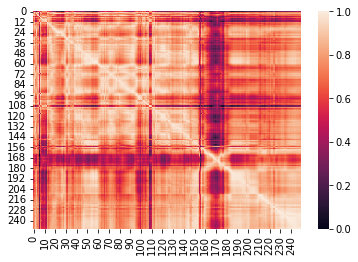

In [12]:
import seaborn as sns
summer_feature = summer_feature[:250]
fall_feature = fall_feature[:250]



matrix = similarity_matrix(summer_feature, fall_feature)
matrix = scaling(matrix)

# matrix = similarity_matrix(test_summer_feature, test_fall_feature)
# matrix = scaling(matrix)

sns.heatmap(matrix)

출력된 결과를 확인하면 대각선으로 밝은 선이 생성되는 것을 확인할 수 있습니다. 하지만 유사도의 차이가 확연하게 차이가 나지 않아서 다른 부분에서도 밝은 부분이 나오는 것을 확인할 수 있습니다.

### 5-3.Precision-Recall curve, f1_score
모델의 성능을 평가하는 지표로 사용되는 방법입니다. 자세한 설명은 아래의 링크를 통해서 확인하시면 됩니다.
(https://sumniya.tistory.com/26)

GroudTruth와 생성한 similarity matrix를 비교해 평가합니다. 

Ground Truth는 대각행렬이기 때문에 np.eye를 통해서 생성합니다. 그 후 아래의 함수를 통해서 Precision-Recall curve를 생성합니다.

In [21]:
# Precision-Recall function
import sklearn.metrics as metrics

def Precision_Recall(similarity):
  thresholds = [i / 1000 for i in range(1000)]
  matrix_shape = len(matrix)
  GT = np.eye(matrix_shape)
  pr_s = []
  re_s = []
  f1_s = []

  for threshold in thresholds:
    test_matrix = similarity > threshold

    right = np.sum(test_matrix * GT == 1)
    precision = right / np.sum(test_matrix)
    recall = right/ np.sum(GT)
    f1 = 2 * precision*recall/(precision+recall)

    pr_s.append(precision)
    re_s.append(recall)
    f1_s.append(f1)

  return pr_s, re_s, f1_s

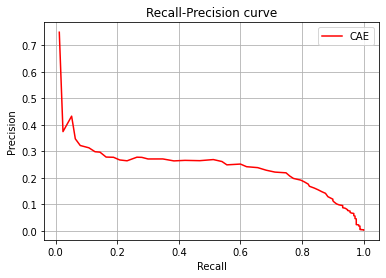

In [22]:
Precision, Recall, F1 = Precision_Recall(matrix)

plt.plot(Recall,Precision,'-r',label="CAE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall-Precision curve")
plt.legend(loc='upper right')
plt.grid()
plt.show()

출력 결과 위와 같은 결과를 확인할 수 있습니다. Precision-recall을 통해서 결과를 확인하는 경우, 그래프가 완만하게 감소하며 recall이 커짐에 따라서 precision이 큰 값을 유지하는 경우 좋은 성능을 가진 모델입니다.

f1_score의 경우 precsion,recall을 이용한 아래와 같은 식을 통한 함수입니다. 

f1_score = 2* (Precision * Recall) /(Precision + Recall)

이중에서 max값을 이용해 결과를 평가하겠습니다.

In [23]:
# f1_score_function
f1_max = max(F1)
print("f1_max = ", round(f1_max,4))

f1_max =  0.3555


## 6.vgg16을 통한 전이학습
이번 프로젝트의 목적은 여러분들이 모델을 생성하거나,컴퓨터 비전 기술 등을 이용해 계절이 다른 장소의 위치를 확인하는 것입니다. 
그러므로 간단한 예시로 vgg16을 통해서 유사도행렬까지만 출력하겠습니다.

아래의 링크를 통해서 자세하게 확인할 수 있습니다.

https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

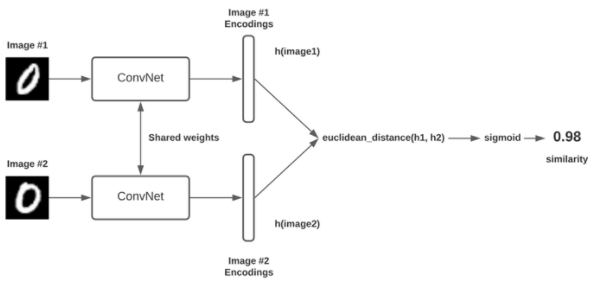

각각의 계절의 이미지를 쌍으로 묶어서 입력으로 생성합니다. 이미지 쌍을 생성할 때 동일한 위치의 이미지 쌍과 다른 위치의 이미지 쌍을 생성합니다. 

ConvNet 자리에 vgg16을 통해 생성한 모델을 이용해서 각각의 이미지의 discriptor을 생성하고 euclidean_distance을 통해서 유사도를 비교합니다.

In [15]:
import keras
from keras import Model
from keras import models
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf

먼저 아래의 코드를 이용해 keras에서 제공하는 pretrained vgg16을 불러옵니다.

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

이미 학습된 모델이기 때문에 전체 모델을 학습을 진행할 때 가중치를 고정하기 위해서 아래와 같이 trainable = False로 변경합니다.

In [18]:
for layers in (vggmodel.layers)[:19]:
    layers.trainable = False

for i, layer in enumerate(vggmodel.layers):
    print(i,":", 'layer name = ',layer.name, "     trainable = ", layer.trainable)

0 : layer name =  input_3      trainable =  False
1 : layer name =  block1_conv1      trainable =  False
2 : layer name =  block1_conv2      trainable =  False
3 : layer name =  block1_pool      trainable =  False
4 : layer name =  block2_conv1      trainable =  False
5 : layer name =  block2_conv2      trainable =  False
6 : layer name =  block2_pool      trainable =  False
7 : layer name =  block3_conv1      trainable =  False
8 : layer name =  block3_conv2      trainable =  False
9 : layer name =  block3_conv3      trainable =  False
10 : layer name =  block3_pool      trainable =  False
11 : layer name =  block4_conv1      trainable =  False
12 : layer name =  block4_conv2      trainable =  False
13 : layer name =  block4_conv3      trainable =  False
14 : layer name =  block4_pool      trainable =  False
15 : layer name =  block5_conv1      trainable =  False
16 : layer name =  block5_conv2      trainable =  False
17 : layer name =  block5_conv3      trainable =  False
18 : layer 

모델의 이미지와 동일한 코드를 생성합니다. vgg16을 discriptor 추출기로 사용합니다.

loss를 생성된 discriptor 간의 차이를 euclidean_distance를 이용하기 위해서 아래와 같이 custom_loss를 생성합니다.

make_pair 함수는 각각의 계절의 이미지를 동일한 위치와, 랜덤한 동일하지 않은 위치의 쌍으로 생성합니다.

In [19]:
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def build_siamese_model(inputShape, embeddingDim=100):
  inputs = Input(inputShape)
  x = vggmodel(inputs)
  x = Flatten()(x)
  x = Dense(4096, activation='relu', input_dim=4 * 4 * 512)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(100)(x)
  model = Model(inputs,outputs)
  
  return model

def euclidean_distance(vectors):
  (featsA, featsB) = vectors

  sumSquared = K.sum(K.square(featsA- featsB), axis=1, keepdims=True)

  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def make_pairs(summer, fall, Mode=0):

  pairImages = []
  pairLabels = []

  numPlace = np.arange(len(summer))

  for idx in numPlace:
    currentImage = summer[idx]
    posImage = fall[idx]
    
    pairImages.append([currentImage,posImage])
    pairLabels.append([1])

  if Mode == 1:
    for idx in numPlace:
      currentImage = summer[idx]

      for num in range(3):
        negIdx = np.where(numPlace != idx)[0]
        negImage = fall[np.random.choice(negIdx)]
        pairImages.append([currentImage,negImage])
        pairLabels.append([0])

  return (np.array(pairImages), np.array(pairLabels))

In [28]:
from tensorflow.keras.layers import Lambda,Input, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
imgA = Input(shape=(150,150,3))
imgB = Input(shape=(150,150,3))
#descriptorExtractor라는 모델 객체를 만든다.
descriptorExtractor = build_siamese_model((150,150,3))
#이제 해당 모델의 출력으로 각 global descriptor를 출력한다.
descsA = descriptorExtractor(imgA)
descsB = descriptorExtractor(imgB)

#람다(lamda)레이어를 통해서, descriptor 사이의 유클리드 거리를 구한다.
distance = Lambda(euclidean_distance)([descsA,descsB])
#이제 출력을 sigmoid를 사용하여 0과 1사이의 출력이 되도록한다.
outputs = Dense(1, activation='sigmoid')(distance)

#최종적으로 입력과 출력을 등록하여 모델 객체를 생성한다.
final_model = Model(inputs=[imgA, imgB], outputs=outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='lambda_8/Sqrt:0', description="created by layer 'lambda_8'")


In [ ]:
def similarity_matrix(a,b):
  w_len, h_len = a.shape[0], b.shape[0]
  matrix = np.zeros((w_len, h_len))

  for i in range(w_len):
    for j in range(h_len):
      matrix[i][j] = cosine_distance(a[i],b[j])

  return matrix

def scaling(matrix):
  result = (matrix -np.min(matrix))/(np.max(matrix) - np.min(matrix))
  
  return result

import seaborn as sns
summer_feature = summer_feature[:250]
fall_feature = fall_feature[:250]


matrix = similarity_matrix(summer_feature, fall_feature)
matrix = scaling(matrix)

sns.heatmap(matrix)

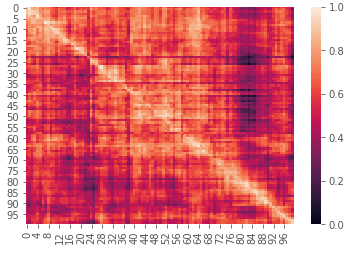

모델을 이용해 결과를 확인한 경우 CAE보다 더 명확한 결과가 생성되는 것을 확인할 수 있습니다.

# 7.각자의 모델, 또는 방법을 이용한 장소 인식
이제 여러분만의 장소 인식 모델을 생성해 결과를 평가하겠습니다. 

기한 : 5.16 ~ 5.29
(추가제출 기한은 6시간을 추가로 드리겠습니다. 단, 감점이 있을 것입니다.)

평가 방법: f1_score을 통해서 결과를 확인할 것입니다. 
여러분들은 각자의 방법으로 descriptor를 추출해서 similarit matrix를 생성해서 보내주시면됩니다.
test_set으로 사용될 데이터 셋은 마감일 2일 전에 업로드하겠습니다. 단, Ground_truth가 대각선이 아닌 랜덤하게 섞여있는 데이터셋입니다. 출력 결과가 대각선이 아니게 나올 것입니다.




최종 제출본은 'similarity_matrix.npy', 'MiniProj#3.ipynb', 프로젝트 보고서를 압축한 '이름_학번.zip'를 업로드하시면 됩니다. 

